In [1]:
from fastai.vision.all import *

sys.path.append(os.path.abspath("../src/"))
from vision_extension import * 

# 1. Looking at the data to gain insights 

In [2]:
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
CSV_PATH = NB_DIR/'..'/'csv'
df = pd.read_csv(CSV_PATH/'data.csv')

Tumor volume in ml rounded to the nearest ten. 

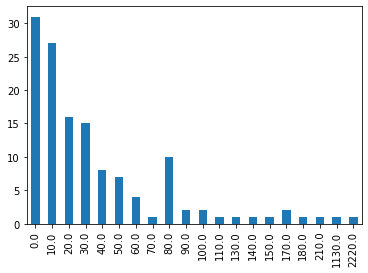

In [3]:
df.tumor_cat.value_counts().sort_index().plot(kind = 'bar')
plt.show()

# 2. Prepare the data

There are only two scans with tumor volume > 1000 ml, these differs significantly from the other obervations. 
Hence, we remove these two scans from our dataset. 

In [4]:
df = df.loc[df.tumor_cat<1000].reset_index(drop=True)

Split the data into train and test based on the `is_test` column predefined in our pandas DataFrame, where data independently annotated by two expert raters(R1 and R2) was marked as test data for evaluation of performance for our final model, as well as for estimation of inter-rater agreement. 

In [5]:
df_test = df.loc[df.is_test].reset_index(drop=True)
df = df.loc[~df.is_test].reset_index(drop=True)
df.shape, df_test.shape

((105, 18), (26, 18))

We divide the remaining data into training and validation using stratified sampling. **Note** that since we have few samples of tumors above 90, we categorize these as 90 (see cell 7). 

In [6]:
df['is_valid'] = False

In [7]:
from sklearn.model_selection import train_test_split

df.loc[df.tumor_cat >90, 'tumor_cat'] = 90
_, val_idx = train_test_split(df.index.tolist(), test_size=0.14, random_state=40, shuffle=True, stratify=df['tumor_cat'].tolist())
df.loc[val_idx, 'is_valid'] = True

In [8]:
df.is_valid.value_counts()

False    90
True     15
Name: is_valid, dtype: int64

Load a segmentation mask saved as .pickle

In [9]:
mask = load_pickle(df.processed_tensor_mask.to_list()[1])

In [10]:
mask.shape, type(mask), np.unique(mask)

(torch.Size([1, 144, 256, 256]), torch.Tensor, array([0., 1.], dtype=float32))

We use the data block API to get our data in a DataLoaders. A DataBlock is built by giving a bunch of information:
- `blocks`: here we pass our custom class PickleImage to load the preprocessed images (normalized and resized) stored as pickles files (normalized and resized) and PickleMaskBlock for segmentation masks. 
- `splitter`: split the data into training data and validation data based on `is_valid` column
- `get_x`: Get the image path from `processed_tensor_img` column
- `get_y`: Get the image path from `processed_tensor_mask` column
- `item_tfms`: Used to pass in the augmentations we want to use on the fly. Defined as `None` since the data is already preprocessed. Look at the [fastai tutorial](https://docs.fast.ai/tutorial.html) to add custom augmentations.

In [11]:
dblock = DataBlock(blocks=(ImageBlock(cls=PickleImage), PickleMaskBlock()), 
                   splitter=ColSplitter('is_valid'),
                   get_x=ColReader('processed_tensor_img'),
                   get_y=ColReader('processed_tensor_mask'),
                   item_tfms=None) 

Defining batch size 

In [12]:
bs = 4

In [13]:
dls = dblock.dataloaders(df, bs=bs)

# 3. Create Model, Loss, Optimizer

In [14]:
from monai.losses import DiceLoss
from monai.networks.nets import UNet

loss_func = DiceLoss(sigmoid=True) 
model = UNet(dimensions=3, in_channels=3, out_channels=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), num_res_units=2).model

In [15]:
opt_func = ranger

In [16]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func)

A summary of the 3D U-Net

In [17]:
learn.summary()

Sequential (Input shape: 4 x 3 x 144 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 16 x 72 x 128 x 
Conv3d                                    1312       True      
InstanceNorm3d                            0          False     
Dropout                                                        
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d                            0          False     
Dropout                                                        
PReLU                                     1          True      
Conv3d                                    1312       True      
____________________________________________________________________________
                     4 x 32 x 36 x 64 x  
Conv3d                                    13856      True      
InstanceNorm3d                            0          False     
Dropout              

# 4. Training
`lr.lr_find()` helps us to find an optimum learning rate value. It uses the technique described in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf). The learning rate is increased from a small value until the loss stops decreasing. 

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.


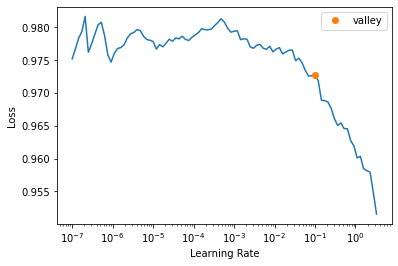

In [18]:
lr_min = learn.lr_find()

In [18]:
lr = 1e-1

`fit_flat_cos()` callback decreases the learning rate rapidly during the final few epochs using a cosine annealing scheduler (as shown in cell 22). This is related to the concept of [super-convergence](https://arxiv.org/pdf/1708.07120.pdf). 

In [19]:
learn.fit_flat_cos(5, lr)

epoch,train_loss,valid_loss,time
0,0.961137,0.961457,00:32
1,0.939144,0.928923,00:23
2,0.899428,0.872213,00:23
3,0.854666,0.925487,00:22
4,0.780743,0.703160,00:22


In [21]:
learn.save('model')

Path('models/model.pth')

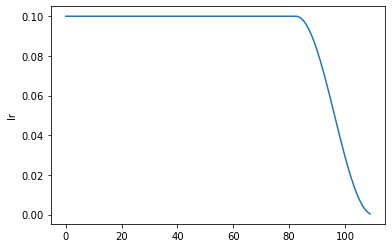

In [22]:
learn.recorder.plot_sched()

# 5. Inference
Loading in our final model (trained for 60 epochs) and predicting on the validation set `(ds_idx=1)` from the dataloader.

In [23]:
learn.load('final_model');

In [24]:
input_imgs, preds,targs = learn.get_preds(ds_idx=1, with_input=True)

In [25]:
preds.shape, targs.shape

(torch.Size([15, 1, 144, 304, 304]), torch.Size([15, 1, 144, 304, 304]))

In [26]:
idx = -1 
targ, pred = targs[idx], torch.sigmoid(preds[idx])
pred = np.where(pred >= 0.5, 1, 0)

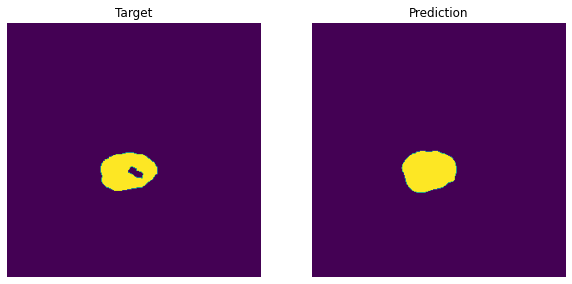

In [27]:
show_targ_pred_masks(targ, pred, slice_nr=72)